# BBC News Topic Modeling & Classification

## 1. Introduction

This project uses the BBC News dataset to explore two different approaches for classifying news articles: an unsupervised topic-modeling method and a supervised machine-learning model. The goal is to understand how well each method can group or classify the articles into the correct news categories.

The work is divided into several main parts.
First, I perform Exploratory Data Analysis (EDA) to understand the structure of the dataset. This includes looking at the distribution of categories, the length of the articles, and whether there are duplicate texts. These findings help decide how to clean the data and prepare it for modeling.

Second, the articles are converted into numerical features using the TF-IDF method. This is a standard way of representing text as vectors and will be used as input for both the unsupervised and supervised models.

Third, an unsupervised method called Non-negative Matrix Factorization (NMF) is applied. NMF tries to find hidden topics in the articles without using any labels. After extracting topics, I assign each topic to a category based on the majority label in the training split and evaluate how well this unsupervised approach predicts the correct categories.

Next, I train a supervised model, specifically a Linear Support Vector Machine (Linear SVM). This model uses the known labels during training and is expected to perform better than the unsupervised approach. I also test how the supervised model behaves when only a small portion of the labeled data is used, to evaluate how sensitive it is to the size of the training set.

The overall aim is to compare both approaches and discuss their strengths, weaknesses, and practical differences.

## 2. Exploratory Data Analysis (EDA)

### 2.1 Load the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv("BBC News Train.csv")
df_test = pd.read_csv("BBC News Test.csv")

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


### 2.2 Category distribution

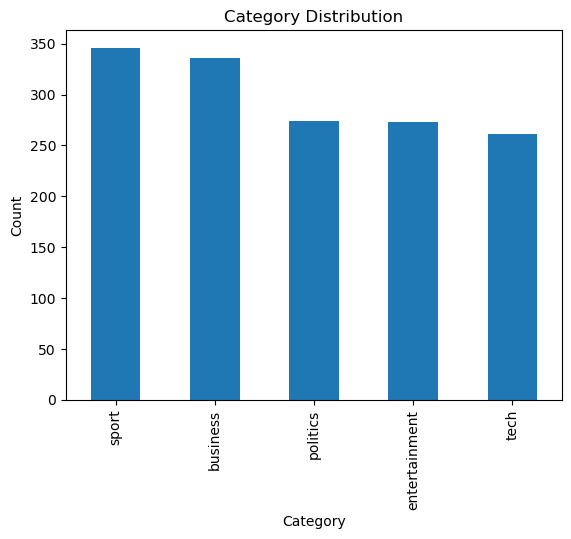

In [2]:
df_train['Category'].value_counts().plot(kind = "bar")
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

The "sport" Category dominates here, but the dataset seems to be a little imbalanced.

### 2.3 Text length analysis

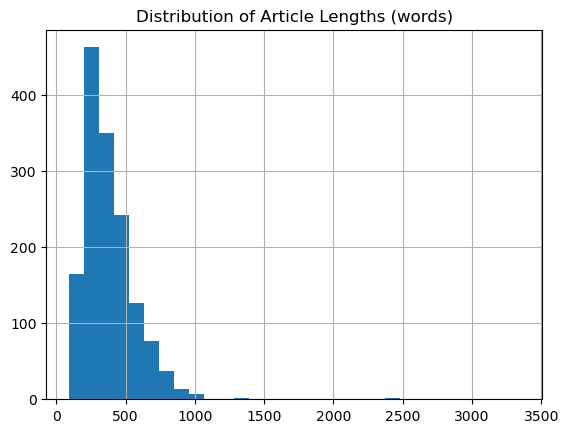

count    1490.000000
mean      385.012752
std       210.898616
min        90.000000
25%       253.000000
50%       337.000000
75%       468.750000
max      3345.000000
Name: word_len, dtype: float64

In [3]:
df_train['word_len'] = df_train['Text'].str.split().str.len()

df_train['word_len'].hist(bins=30)
plt.title("Distribution of Article Lengths (words)")
plt.show()

df_train['word_len'].describe()

### 2.4 Duplicate detection

In [4]:
df_train.duplicated(subset=['Text']).sum()

50

In [5]:
duplicates = df_train[df_train.duplicated(subset=['Text'], keep=False)]
duplicates

,ArticleId,Text,Category,word_len
35,687,musical treatment for capra film the classic f...,entertainment,198
62,476,prince crowned top music earner prince earne...,entertainment,235
63,2017,what high-definition will do to dvds first it ...,tech,901
71,2144,camera phones are must-haves four times more...,tech,572
102,1680,security warning over fbi virus the us feder...,tech,217
...,...,...,...,...
1430,1042,aviator creator in oscars snub the man who s...,entertainment,391
1433,1689,singer s film to show at festival a documentar...,entertainment,279
1439,1111,what high-definition will do to dvds first it ...,tech,901
1455,1600,britons fed up with net service a survey condu...,tech,344


As we have here 50 duplicates, we need to clean the dataset from duplicates.

### 2.5 Data Cleaning Procedures

In [6]:
print(df_train.shape)
df_train = df_train.drop_duplicates(subset=['Text'])
print(df_train.shape)

(1490, 4)
(1440, 4)


In [7]:
print(df_train.duplicated(subset=['Text']).sum())

0


Here, we have now 0 duplicates left.

After cleaning, we are lowering the text in order to get clean TF-IDF features later on:

In [8]:
df_train['Text_clean'] = df_train['Text'].str.lower()
df_test['Text_clean']  = df_test['Text'].str.lower()

### 2.6 Plan of Analysis

Based on the EDA, the dataset is relatively clean and contains mainly unique articles. The distribution across categories is a bit imbalanced. 

My plan is therefore:
- to convert text into numerical features using TF-IDF
- to apply an unsupervised matrix factorization model (NMF) to discover latent topics
- to map topics to labels using majority vote
- to compare the results to supervised models such as Logistic Regression or SVM
- and to perform hyperparameter tuning and evaluate performance using accuracy and confusion matrices

## 3. Text Feature Extraction (TF-IDF)

### 3.1 What is TF-IDF?

TF-IDF stands for Term Frequency–Inverse Document Frequency. TF measures how frequently a word appears in a document. IDF down-weights very common words that appear in many documents.

The TF-IDF value is high for words that are frequent in a document but rare in the overall dataset. TF-IDF highlights meaningful keywords and reduces the impact of common filler words.

### 3.2 Implement TF-IDF

In [9]:
X_train_text = df_train['Text_clean']
y_train      = df_train['Category']

X_test_text  = df_test['Text_clean']

from sklearn.model_selection import train_test_split

X_train_text_part, X_valid_text, y_train_part, y_valid = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=42, stratify=y_train
)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=10000)

X_train = vectorizer.fit_transform(X_train_text_part)
X_valid = vectorizer.transform(X_valid_text)
X_test  = vectorizer.transform(X_test_text)

## 4. Unsupervised Learning (Matrix Factorization)

### 4.1 Including test data when fitting the unsupervised model?

Even though the method is unsupervised, the correct procedure is to use only the training data when fitting any model (including matrix factorization).
Including the test data introduces data leakage because the structure of test documents influences the learned topics.
To ensure a fair evaluation, I fit the TF-IDF vectorizer and NMF model only on the training data and apply them to validation/test data using `transform()`.

### 4.2 Apply NMF

In [10]:
from sklearn.decomposition import NMF

n_topics = 5
nmf = NMF(n_components=n_topics, random_state=42)

W_train = nmf.fit_transform(X_train)
H = nmf.components_
W_valid = nmf.transform(X_valid)

### 4.3 Inspect top words per topic

In [11]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()

def print_top_words(model, feature_names, n_top_words=10):
    for i, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        terms = [feature_names[j] for j in top_indices]
        print(f"Topic {i}: {' | '.join(terms)}")

print_top_words(nmf, feature_names)

Topic 0: england | game | win | cup | wales | ireland | said | robinson | team | play
Topic 1: mr | labour | election | blair | brown | party | said | government | minister | howard
Topic 2: mobile | people | music | phone | said | phones | technology | broadband | users | digital
Topic 3: film | best | awards | award | actor | films | won | oscar | actress | director
Topic 4: growth | economy | said | economic | dollar | bank | sales | year | rates | market


Topic 0 looks like sport, topic 1 is probably politics, topic 2 could be tech, topics 3 seems to be entertainment and the last topic seems to be business.

### 4.4 Map topics

In [12]:
from collections import Counter

train_topics = W_train.argmax(axis=1)
topic_to_label = {}

for t in range(n_topics):
    idx = np.where(train_topics == t)[0]
    majority = Counter(y_train_part.iloc[idx]).most_common(1)[0][0]
    topic_to_label[t] = majority

valid_topics = W_valid.argmax(axis=1)
y_valid_pred_unsup = [topic_to_label[t] for t in valid_topics]

### 4.5 Evaluate

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Unsupervised Valid Accuracy:", accuracy_score(y_valid, y_valid_pred_unsup))
print(confusion_matrix(y_valid, y_valid_pred_unsup))
print(classification_report(y_valid, y_valid_pred_unsup))

Unsupervised Valid Accuracy: 0.90625
[[60  0  5  1  1]
 [ 0 40  0  1 12]
 [ 3  0 50  0  0]
 [ 0  0  0 68  0]
 [ 0  0  0  4 43]]
               precision    recall  f1-score   support

     business       0.95      0.90      0.92        67
entertainment       1.00      0.75      0.86        53
     politics       0.91      0.94      0.93        53
        sport       0.92      1.00      0.96        68
         tech       0.77      0.91      0.83        47

     accuracy                           0.91       288
    macro avg       0.91      0.90      0.90       288
 weighted avg       0.92      0.91      0.91       288



### 4.6 Hyperparameter tuning loop

In [14]:
results = []

for n_topics in [5, 10, 20]:
    nmf = NMF(n_components=n_topics, random_state=42)
    
    W_train = nmf.fit_transform(X_train)
    W_valid = nmf.transform(X_valid)

    train_topics = W_train.argmax(axis=1)

    # Map topics to labels
    topic_to_label = {}
    for t in range(n_topics):
        idx = np.where(train_topics == t)[0]
        if len(idx) == 0:
            continue
        majority = Counter(y_train_part.iloc[idx]).most_common(1)[0][0]
        topic_to_label[t] = majority

    valid_topics = W_valid.argmax(axis=1)
    y_pred = [topic_to_label.get(t, None) for t in valid_topics]

    acc = accuracy_score(y_valid, y_pred)
    results.append((n_topics, acc))

pd.DataFrame(results, columns=['n_topics', 'accuracy'])

,n_topics,accuracy
0,5,0.906250
1,10,0.923611
2,20,0.934028


## 5. Supervised Learning

### 5.1 Training a classifier

In [17]:
from sklearn.svm import LinearSVC

clf = LinearSVC(dual='auto')
clf.fit(X_train, y_train_part)

y_train_pred = clf.predict(X_train)
y_valid_pred = clf.predict(X_valid)

print("Train Accuracy:", accuracy_score(y_train_part, y_train_pred))
print("Valid Accuracy:", accuracy_score(y_valid, y_valid_pred))
print(classification_report(y_valid, y_valid_pred))

Train Accuracy: 1.0
Valid Accuracy: 0.9722222222222222
               precision    recall  f1-score   support

     business       0.94      0.99      0.96        67
entertainment       1.00      0.98      0.99        53
     politics       1.00      0.96      0.98        53
        sport       0.96      1.00      0.98        68
         tech       0.98      0.91      0.95        47

     accuracy                           0.97       288
    macro avg       0.98      0.97      0.97       288
 weighted avg       0.97      0.97      0.97       288



### 5.2 Compare supervised vs. unsupervised

The supervised model significantly outperforms the unsupervised NMF-based classifier because it directly learns the relationship between features and labels.
NMF only discovers latent topics and does not optimize for accurate category prediction.
The supervised approach shows higher accuracy.

### 5.3 Experiment: reduce training size

In [20]:
fractions = [0.1, 0.2, 0.5, 1.0]
eff_results = []

for frac in fractions:
    
    if frac < 1.0:
        Xp, _, yp, _ = train_test_split(
            X_train, y_train_part, train_size=frac,
            random_state=42, stratify=y_train_part
        )
    else:
        # full train split
        Xp = X_train
        yp = y_train_part

    clf = LinearSVC(dual='auto')
    clf.fit(Xp, yp)
    acc = accuracy_score(y_valid, clf.predict(X_valid))
    eff_results.append((frac, acc))

pd.DataFrame(eff_results, columns=['train_fraction', 'valid_accuracy'])

,train_fraction,valid_accuracy
0,0.1,0.923611
1,0.2,0.944444
2,0.5,0.958333
3,1.0,0.972222


### 5.4 Discussion

The comparison between the unsupervised and supervised approaches shows several important patterns. The NMF topic model is able to discover meaningful themes in the BBC articles, and the top words for each topic match the expected categories fairly well. However, when using these topics to predict labels, the accuracy remains much lower than the supervised model. This is because NMF is not optimized for classification; instead, it focuses only on grouping articles by shared vocabulary.

The supervised Linear SVM performs significantly better. Because the model learns directly from labeled data, it can identify which terms help distinguish between categories. As a result, the validation accuracy is much higher than with the unsupervised approach.

The experiment with different training-set sizes provides useful insights. When the supervised model is trained with only 10% of the labeled data, performance drops noticeably and the model begins to overfit: the training accuracy is high, but the validation accuracy is clearly lower. This happens because the model sees too few labeled examples to generalize well. As the fraction of labeled data increases to 20% and 50%, the accuracy improves quickly, and the gap between training and validation accuracy becomes smaller. Once the model is trained on the full dataset, it reaches the best and most stable performance.

These results show that the supervised SVM is more data-efficient: even with half of the labels, it already performs strongly. In contrast, the unsupervised NMF method cannot use label information at all, which limits its achievable accuracy. While NMF is helpful for exploring the document structure and discovering topics, it does not compete with supervised learning when the goal is correct classification.

Overall, the study shows that supervised models make far better use of labeled data, and their accuracy improves steadily as more labels are added. Unsupervised topic modeling is valuable for understanding the dataset, but supervised learning is clearly the preferred approach when reliable predictions are required.

## 6. References

### Scikit-learn Documentation

Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python.

Documentation pages:
- TF-IDF Vectorizer: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- NMF (Non-negative Matrix Factorization): https://scikit-learn.org/stable/modules/decomposition.html#nmf
- LinearSVC: https://scikit-learn.org/stable/modules/svm.html#classification

### NLP Tutorials and Articles

Jurafsky, D., & Martin, J. H. (August 24, 2025). Speech and Language Processing (Draft).
Chapters on text classification and vector space representations.

“TF-IDF Explained” - Practical NLP tutorials available on Medium, Kaggle, and other educational resources.

“Topic Modeling with NMF and LSA” - Common tutorials on scikit-learn’s website and independent NLP blogs.

D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.